In [5]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import os 
import json
cwd = os.getcwd()
cwd



'/content'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!unzip '/content/drive/My Drive/NeuralNetworkprojects/Homework1/artificial-neural-networks-and-deep-learning-2020'

Archive:  /content/drive/My Drive/NeuralNetworkprojects/Homework1/artificial-neural-networks-and-deep-learning-2020.zip
replace MaskDataset/test/10001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [8]:
!ls /content/MaskDataset


test  train_gt.json  training


In [9]:
dataset_dir = os.path.join(cwd, 'MaskDataset')
SEED=1234
training_dir = os.path.join(dataset_dir, 'training')
test_dir = os.path.join(dataset_dir, 'test')
bs=32
img_h=384
img_w=384


In [10]:
#import some libraraies
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split


Compute number of elements in each class in order to balance it if there is a class with much more elements

In [11]:

import json
def inputImage_calculator(jsonpath):
  class0 = class1 = class2 = 0
  with open(os.path.join(jsonpath)) as f:
    dic = json.load(f)
    for key, value in dic.items():
      if value == 0:
        class0+=1
      elif value == 1:
        class1+=1
      else:
        class2+=1
    return class0, class1, class2

In [12]:
jsonpath = os.path.join(cwd, 'MaskDataset','train_gt.json')
c0, c1, c2 = inputImage_calculator(jsonpath=jsonpath)
print('Number of elements in each class:\n', 'class 0=', c0, '\n' 'class 1=' , c1 , '\n' 'class 2=', c2)


Number of elements in each class:
 class 0= 1900 
class 1= 1897 
class 2= 1817


In [13]:
# setting up the training data

dataset_dir=os.path.join(cwd,'MaskDataset')
with open(os.path.join(dataset_dir,"train_gt.json")) as f:
  dic = json.load(f)
traindf = pd.DataFrame(dic.items())
traindf.rename(columns = {0:'filename', 1:'class'}, inplace = True)
traindf["class"] = traindf["class"].astype({'class':'string'})
traindf

,filename,class
0,14985.jpg,0
1,13358.jpg,0
2,10210.jpg,0
3,18202.jpg,0
4,14962.jpg,0
...,...,...
5609,14383.jpg,2
5610,11787.jpg,2
5611,15770.jpg,2
5612,10934.jpg,2


In [14]:
# Shuffle the dataset
import pandas as pd
pd.options.mode.chained_assignment = None
np.random.RandomState(seed=42).shuffle(traindf['filename'])
np.random.RandomState(seed=42).shuffle(traindf['class'])
traindf

,filename,class
0,16398.jpg,2
1,16608.jpg,1
2,13811.jpg,0
3,15567.jpg,2
4,15478.jpg,1
...,...,...
5609,14915.jpg,1
5610,10670.jpg,2
5611,16733.jpg,2
5612,12208.jpg,2


In [15]:
# set the train dataframe into two parts trainDF and validDF with train_test_split
from sklearn.model_selection import train_test_split
train_dataframe, valid_dataframe = train_test_split(traindf, test_size= 0.2, random_state=SEED)
train_dataframe


,filename,class
2816,14914.jpg,2
1020,13366.jpg,0
3909,12024.jpg,0
548,11358.jpg,0
165,11943.jpg,1
...,...,...
664,13809.jpg,0
3276,10983.jpg,0
1318,13628.jpg,0
723,14243.jpg,1


In [16]:
# Test Data Frame

test_data_gen = ImageDataGenerator(rescale=1./255)
 
test_dir = os.path.join(dataset_dir, 'test')

test_images = [f for f in os.listdir(test_dir)]
test_dataframe = pd.DataFrame(test_images)
test_dataframe.rename(columns = {0:'filename'}, inplace = True)
test_dataframe["class"] = None

test_dataframe

,filename,class
0,16278.jpg,None
1,14391.jpg,None
2,15017.jpg,None
3,14113.jpg,None
4,13911.jpg,None
...,...,...
445,14230.jpg,None
446,10581.jpg,None
447,13100.jpg,None
448,12448.jpg,None


In [17]:
# Data Generators
# augmentation
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

apply_data_augmentation = True
# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(rotation_range=10,
                                        width_shift_range=10,
                                        height_shift_range=10,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        #shuffle=True,
                                        vertical_flip=True,
                                        fill_mode='wrap',
                                        cval=0,
                                        rescale=1./255,
                                        preprocessing_function=preprocess_input)
else:
    train_data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

valid_data_gen=ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
test_data_gen=ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)




In [18]:
# Flow_From_DataFrames

train_generator=train_data_gen.flow_from_dataframe(
    dataframe=train_dataframe,
    directory=training_dir,
    x_col="filename",
    y_col="class",
    batch_size=bs,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(img_h,img_w))

valid_generator=valid_data_gen.flow_from_dataframe(
    dataframe=valid_dataframe,
    directory=training_dir,
    x_col="filename",
    y_col="class",
    batch_size=bs,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(img_h,img_w))

test_generator=test_data_gen.flow_from_dataframe(
    dataframe=test_dataframe,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(img_h,img_w))


Found 4491 validated image filenames belonging to 3 classes.
Found 1123 validated image filenames belonging to 3 classes.
Found 450 validated image filenames.


In [19]:
# Create Dataset objects
# ----------------------
num_classes=3
# Training
train_dataset = tf.data.Dataset.from_generator(lambda: train_generator,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
# Repeat
# Without calling the repeat function the dataset will be empty after consuming all the images (after first epoch)
train_dataset = train_dataset.repeat()


# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_generator, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
# Repeat
valid_dataset = valid_dataset.repeat()

# Test
# ----
test_dataset = tf.data.Dataset.from_generator(lambda: test_generator,
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=([None, img_h, img_w, 3], [None, num_classes]))
# Repeat
test_dataset = valid_dataset.repeat()



[]

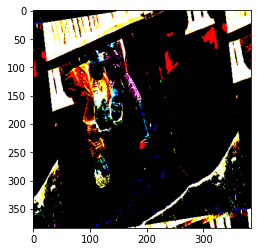

In [20]:

import matplotlib.pyplot as plt
%matplotlib inline 
iterator=iter(train_dataset)
augmented_img, target=next(iterator)
augmented_img=np.array(augmented_img[0])
augmented_img=augmented_img*255
plt.imshow(np.uint8(augmented_img))
plt.plot()

# Transfer Learning
## e.g., VGG16

In [21]:
#Load Vgg16 model
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h,img_w,3))

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 384, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 192, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 96, 96, 128)       0     

In [23]:
# Create Model
# ------------

#Finetuning setting
finetune = True
if finetune:
  freez_until = 15
  for layer in vgg.layers[:freez_until]:
    layer.trainable = False
else:
  vgg.trainable = False

model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

# Visualize created model as a table
model.summary()

# Visualize initialized weights
model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 12, 12, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               37749248  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 52,465,475
Trainable params: 44,830,211
Non-trainable params: 7,635,264
_________________________________________________________________


[<tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32, numpy=
 array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
    

## Prepare the model for training

In [24]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

##Mounting TensorBoard

In [25]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Neural Network projects/Homework1/transfer_learning_experiments/

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-11-22 20:37:01.298542: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT]
                   [--

## Training with callbacks

In [ ]:
import os
from datetime import datetime

cwd = '/content/drive/My Drive/Neural Network projects/Homework1'

exps_dir = os.path.join(cwd, 'transfer_learning_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)

# reduce learning rate
# --------------
reduce_learning_rate = True
if reduce_learning_rate:
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                         patience=2, verbose=1)
    callbacks.append(reduce_learning_rate)


model.fit(x=train_dataset,
          epochs=30,  #### set repeat in training dataset
          steps_per_epoch=len(train_generator),
          validation_data=valid_dataset,
          validation_steps=len(valid_generator), 
          callbacks=callbacks)


Epoch 1/30
  3/141 [..............................] - ETA: 1:31:02 - loss: 3.3137 - accuracy: 0.3438

In [ ]:
test_generator.reset()

In [ ]:
Y_prediction = model.predict_generator(test_generator, len(test_generator))
# Convert predictions classes to one hot vectors 
print(Y_prediction)
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
print(Y_pred_classes)

In [ ]:
# This function create a csv file
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
from PIL import Image
import numpy as np

image_filenames = next(os.walk('/content/MaskDataset/test'))[2]
results = {}
dr = os.listdir('/content/MaskDataset/test')
for i in range(len(dr)):
  img = dr[i]

  results[img] = Y_pred_classes[i] 

create_csv(results)